In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
import random as rnd

import SP_anisotropy_class as SPN

#3D plotting
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [3]:
#Ignore the first 50 elements of the output
spacer = 50

In [4]:
def Ridge_regression(S, Y, alpha):
    '''
    For a linear layer we can solve the weights by a direct method
    If the error function is the mean square error given by
        E = |Y - S * W |^2 + \alpha |W|^2
    where the L2 norm is being applied and the variables are
        Y = [Nsamples x Noutputs] is the desired output
        S = [Nsamples x Nweights] is the input signal
        W = [Nweights x Noutputs] is the weight matrix
    To minimise E we need to solve:
        S^T * Y = (S^T * S  + \alpha I) * W
        W = (S^T*S + \alpha I)^-1 * S^T * Y
    '''
    STS = np.matmul(S.T, S)
    STY = np.matmul(S.T, Y)
    Sdag = np.linalg.pinv(STS + alpha*np.eye(len(STS)))
    return(np.matmul(Sdag, STY))

In [5]:
def NARMA10(Ns):
    # Ns is the number of samples
    u = np.random.random(Ns+50+spacer)*0.5
    y = np.zeros(Ns+50+spacer)
    for k in range(10,Ns+50+spacer):
        y[k] = 0.3*y[k-1] + 0.05*y[k-1]*np.sum(y[k-10:k]) + 1.5*u[k-1]*u[k-10] + 0.1
    return(u[50:],y[50+spacer:])

In [6]:
def mask_NARMA10(m0,Nvirt):
    # Nvirt is the number of virtual nodes
    mask = []
    for i in range(Nvirt):
        mask.append(rnd.choice([-1,1])*m0)
    mask = mask
    return(mask)

In [7]:
def NRMSE(Y,Y_pred):
    var = np.var(Y)
    return np.sqrt(np.square(Y_pred-Y).mean()/var)

def NRMSE_list(y,y_pred):
    Y = np.array(y)
    Y_pred = np.array(y_pred)
    return(NRMSE(Y,Y_pred))

In [8]:
h = 0.4
theta_H = 90
k_s_0 = 0
phi = 45
f0 = 1e10
class Single_Node_Reservoir_NARMA10:
    
    def __init__(self, Nvirt, T_theta_ratio, m0, gamma, beta_prime = 10, k_off = 0., bias = True, joined_states = False):
        self.Nin = 1
        self.Nvirt = Nvirt
        self.Nout = 1
        
        self.spn = SPN.SP_Network(h,theta_H,k_s_0,phi,beta_prime)
        SPN.calculate_energy_barriers(self.spn)
        self.T = 1./(self.spn.get_omega_prime()*f0)
        self.theta = self.T/T_theta_ratio
        self.tau = self.Nvirt*self.theta
        
        self.m0 = m0
        self.M = mask_NARMA10(m0,Nvirt)
        if bias:
            if joined_states:
                self.W = np.zeros((2*Nvirt+1,1))
            else:
                self.W = np.zeros((Nvirt+1,1))
        else:
            if joined_states:
                self.W = np.zeros((2*Nvirt,1))
            else:
                self.W = np.zeros((Nvirt,1))
        
        self.gamma = gamma
        self.k_off = k_off
        
        self.use_bias = bias
    
    def gen_signal(self, u):
        Ns = len(u)
        if self.use_bias:
            print("Use bias")
            S = np.zeros((Ns,self.Nvirt+1))
        else:
            S = np.zeros((Ns,self.Nvirt))
        
        for k in range(Ns):
            if k%100==0:
                print(k)
            for i in range(self.Nvirt):
                j = self.M[i]*u[k] + self.k_off #Offset
                self.spn.k_s = j + self.gamma*S[k-1,i] #Feedback
                SPN.calculate_energy_barriers(self.spn)
                self.spn.evolve(f0,self.theta)
                S[k,i] = self.spn.get_m()
        
        if self.use_bias:
            for k in range(Ns):
                S[k,self.Nvirt] = 1
        
        return(S[spacer:])
    
    def gen_signal_fast(self,u):
        Ns = len(u)
        if self.use_bias:
            print("Use bias")
            S = np.zeros((Ns,self.Nvirt+1))
        else:
            S = np.zeros((Ns,self.Nvirt))
        
        for k in range(Ns):
            if k%100==0:
                print(k)
            for i in range(self.Nvirt):
                j = self.M[i]*u[k] + self.k_off #Offset
                self.spn.k_s = j + self.gamma*S[k-1,i] #Feedback 
                self.spn.evolve_fast(f0,self.theta)
                S[k,i] = self.spn.get_m_fast()
        
        if self.use_bias:
            for k in range(Ns):
                S[k,self.Nvirt] = 1
        
        return(S[spacer:])
    
    def gen_signal_fast_2_inputs(self, u, back_input_ratio):
        Ns = len(u)
        Nin = int(self.Nvirt*back_input_ratio)
        if self.use_bias:
            print("Use bias")
            S = np.zeros((Ns,self.Nvirt+1))
        else:
            S = np.zeros((Ns,self.Nvirt))
            
        for k in range(Ns):
            if k%100==0:
                print(k)
            for i in range(Nin):
                #Input at k-1
                j = self.M[i]*u[k-1] + self.k_off #Offset
                self.spn.k_s = j + self.gamma*S[k-1,i] #Feedback
                self.spn.evolve_fast(f0,self.theta)
                S[k,i] = self.spn.get_m_fast()
            for i in range(Nin,self.Nvirt):
                #Input at k
                j = self.M[i]*u[k] + self.k_off #Offset
                self.spn.k_s = j + self.gamma*S[k-1,i] #Feedback 
                self.spn.evolve_fast(f0,self.theta)
                S[k,i] = self.spn.get_m_fast()
                
        if self.use_bias:
            for k in range(Ns):
                S[k,self.Nvirt] = 1
        
        return(S[spacer:])
    
    def gen_signal_fast_delayed_feedback(self, u, delay_fb):
        Ns = len(u)
        if self.use_bias:
            print("Use bias")
            S = np.zeros((Ns,self.Nvirt+1))
        else:
            S = np.zeros((Ns,self.Nvirt))
            
        for k in range(Ns):
            if k%100==0:
                print(k)
            for i in range(self.Nvirt):
                j = self.M[i]*u[k] + self.k_off #Offset
                self.spn.k_s = j + self.gamma*S[k-1,i-delay_fb] #Delayed Feedback 
                self.spn.evolve_fast(f0,self.theta)
                S[k,i] = self.spn.get_m_fast()
                
        if self.use_bias:
            for k in range(Ns):
                S[k,self.Nvirt] = 1
        
        return(S[spacer:])
    
    def gen_signal_delayed_feedback_without_SPN(self, u, delay_fb):
        Ns = len(u)
        if self.use_bias:
            print("Use bias")
            J = np.zeros((Ns,self.Nvirt+1))
        else:
            J = np.zeros((Ns,self.Nvirt))
            
        # Artificial nonlinearity
        #f = lambda x: x
        f=np.tanh
            
        for k in range(Ns):
            if k%100==0:
                print(k)
            for i in range(self.Nvirt):
                j = self.M[i]*u[k] + self.k_off #Offset
                J[k,i] = f(j + self.gamma*J[k-1,i-delay_fb]) #Delayed Feedback 
                
        if self.use_bias:
            for k in range(Ns):
                J[k,self.Nvirt] = 1
        
        return(J[spacer:])
    
    def gen_signal_without_SPN(self,u):
        Ns = len(u)
        if self.use_bias:
            print("Use bias")
            J = np.zeros((Ns,self.Nvirt+1))
        else:
            J = np.zeros((Ns,self.Nvirt))
        
        for k in range(Ns):
            if k%100==0:
                print(k)
            for i in range(self.Nvirt):
                j = self.M[i]*u[k] + self.k_off #Offset
                J[k,i] = j + self.gamma*J[k-1,i] #J will be useful to test the role of memory and nonlinearity
        
        if self.use_bias:
            for k in range(Ns):
                J[k,self.Nvirt] = 1
        
        return(J[spacer:])
    
    def train(self, S, y, S_valid, y_valid):
        alphas = np.logspace(-15,0,20)
        alphas[0] = 0.
        
        Ns = S.shape[0]
        Ns_valid = S_valid.shape[0]
        Y = y.reshape((Ns,1))
        Y_valid = y_valid.reshape((Ns_valid,1))
        
        errs = np.zeros(alphas.shape)
        for i in range(len(alphas)):
            self.W = Ridge_regression(S, Y, alphas[i])
            Y_pred = np.array(self.predict(S)).reshape(Ns,1)
            Y_pred_valid = np.array(self.predict(S_valid)).reshape(Ns_valid,1)
            errs[i] = NRMSE(Y_valid, Y_pred_valid)
            print("alpha = " + str(alphas[i]) + " ; NRMSE (train) = " + str(int(1000*NRMSE(Y,Y_pred))/1000) + " ; NRMSE (validation) = " + str(int(1000*NRMSE(Y_valid, Y_pred_valid))/1000))
    
        alpha_opt = alphas[np.argmin(errs)]
        print('Optimal alpha = ' + str(alpha_opt) + ' with NRMSE (validation) = ' + str(np.min(errs)))
        self.W = Ridge_regression(S, Y, alpha_opt)
    
    def train_without_SPN(self, J, y, J_valid, y_valid):
        alphas = np.logspace(-15,0,20)
        alphas[0] = 0.
        
        Ns = J.shape[0]
        Ns_valid = J_valid.shape[0]
        Y = y.reshape((Ns,1))
        Y_valid = y_valid.reshape((Ns_valid,1))
        
        errs = np.zeros(alphas.shape)
        for i in range(len(alphas)):
            self.W = Ridge_regression(J, Y, alphas[i])
            Y_pred_valid = np.array(self.predict(J_valid)).reshape(Ns_valid,1)
            errs[i] = NRMSE(Y_valid, Y_pred_valid)
            print(alphas[i], NRMSE(Y_valid, Y_pred_valid))
    
        alpha_opt = alphas[np.argmin(errs)]
        print('Optimal alpha = '+str(alpha_opt)+' with NRMSE = '+str(np.min(errs)))
        self.W = Ridge_regression(J, Y, alpha_opt)
    
    def predict(self, S):
        Ns = S.shape[0]
        return(np.matmul(S, self.W).reshape(1,Ns).tolist()[0])
    
    #Time lists (in ns)
    
    def get_time_list_u(self, u):
        #We need to make sure that time_u has Ns elements with a delay tau
        Ns = len(u)
        t_u = 0
        time_u = [t_u]
        while len(time_u)<Ns:
            t_u += self.tau
            time_u.append(t_u)
        return(np.array(time_u)*1e9)
    
    def get_time_list_y(self, y):
        #We need to make sure that time_y has Ns elements with a delay tau
        Ns = len(y)
        t_y = spacer*self.tau
        time_y = [t_y]
        while len(time_y)<Ns:
            t_y += self.tau
            time_y.append(t_y)
        return(np.array(time_y)*1e9)
    
    def get_time_list_S(self, S):
        Ns = S.shape[0]
        return(np.arange(spacer*self.tau,(Ns+spacer)*self.tau,self.theta)*1e9)
    
    #Joined states
    
    def get_joined_states_signal(self, S):
        Ns = S.shape[0]
        if self.use_bias:
            S_joined = np.zeros((2*self.Nvirt+1,Ns))
        else:
            S_joined = np.zeros((2*self.Nvirt,Ns))
            
        for k in range(Ns):
            S_joined[k,:self.Nvirt] = S[k-1,:self.Nvirt]
            S_joined[k,self.Nvirt:2*self.Nvirt] = S[k,:self.Nvirt]
            if self.use_bias:
                S_joined[k,-1] = 1
        
        return(S_joined)

## No feedback

### Role of memory ($T/\theta$)

In [28]:
bp_list = [10]
T_theta_list = np.logspace(-.5,.5,5)

Ntrain = 1000
Nvalid = 1000
Ntest = 500

Nv = 800
m0 = 1e-2
gamma = 0.

NRMSE_train_mean_vs_bp = []
NRMSE_valid_mean_vs_bp = []
NRMSE_test_mean_vs_bp = []
NRMSE_train_std_vs_bp = []
NRMSE_valid_std_vs_bp = []
NRMSE_test_std_vs_bp = []

for bp in bp_list:
    

    NRMSE_train_mean = []
    NRMSE_valid_mean = []
    NRMSE_test_mean = []
    NRMSE_train_std = []
    NRMSE_valid_std = []
    NRMSE_test_std = []

    N = 1

    for T_theta in T_theta_list:
        print(T_theta)
        NRMSE_train = []
        NRMSE_valid = []
        NRMSE_test = []

        for i in range(N):
            (u,y) = NARMA10(Ntrain)
            (u_valid,y_valid) = NARMA10(Nvalid)
            (u_test,y_test) = NARMA10(Ntest)
            
            net = Single_Node_Reservoir_NARMA10(Nv,T_theta,m0,gamma,beta_prime=bp)

            S = net.gen_signal_fast(u)
            S_valid = net.gen_signal_fast(u_valid)
            S_test = net.gen_signal_fast(u_test)

            net.train(S,y,S_valid,y_valid)

            y_pred_train = net.predict(S)
            y_pred_valid = net.predict(S_valid)
            y_pred_test = net.predict(S_test)

            NRMSE_train.append(NRMSE_list(y,y_pred_train))
            NRMSE_valid.append(NRMSE_list(y_valid,y_pred_valid))
            NRMSE_test.append(NRMSE_list(y_test,y_pred_test))

        NRMSE_train_mean.append(np.mean(NRMSE_train))
        NRMSE_valid_mean.append(np.mean(NRMSE_valid))
        NRMSE_test_mean.append(np.mean(NRMSE_test))
        NRMSE_train_std.append(np.std(NRMSE_train,ddof=min(1,N-1)))
        NRMSE_valid_std.append(np.std(NRMSE_valid,ddof=min(1,N-1)))
        NRMSE_test_std.append(np.std(NRMSE_test,ddof=min(1,N-1)))
    
    NRMSE_train_mean_vs_bp.append(NRMSE_train_mean)
    NRMSE_valid_mean_vs_bp.append(NRMSE_valid_mean)
    NRMSE_test_mean_vs_bp.append(NRMSE_test_mean)
    NRMSE_train_std_vs_bp.append(NRMSE_train_std)
    NRMSE_valid_std_vs_bp.append(NRMSE_valid_std)
    NRMSE_test_std_vs_bp.append(NRMSE_test_std)

0.31622776601683794
Use bias
0
100
200
300
400
500
600
700
800
900
1000
Use bias
0
100
200
300
400
500
600
700
800
900
1000
Use bias
0
100
200
300
400
500
alpha = 0.0 ; NRMSE (train) = 0.858 ; NRMSE (validation) = 0.88
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.858 ; NRMSE (validation) = 0.88
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.858 ; NRMSE (validation) = 0.88
alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.858 ; NRMSE (validation) = 0.88
alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.858 ; NRMSE (validation) = 0.88
alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.858 ; NRMSE (validation) = 0.88
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.858 ; NRMSE (validation) = 0.88
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.858 ; NRMSE (validation) = 0.88
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.858 ; NRMSE (validation) = 0.88
alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.858 ; NRMSE (validation) = 0.88
alpha = 7.847599703514623e-08 ; NRMSE (t

alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.861 ; NRMSE (validation) = 0.87
alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.862 ; NRMSE (validation) = 0.87
alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.862 ; NRMSE (validation) = 0.87
alpha = 4.832930238571752e-07 ; NRMSE (train) = 0.862 ; NRMSE (validation) = 0.87
alpha = 2.976351441631313e-06 ; NRMSE (train) = 0.862 ; NRMSE (validation) = 0.87
alpha = 1.8329807108324375e-05 ; NRMSE (train) = 0.862 ; NRMSE (validation) = 0.87
alpha = 0.00011288378916846884 ; NRMSE (train) = 0.862 ; NRMSE (validation) = 0.87
alpha = 0.000695192796177562 ; NRMSE (train) = 0.863 ; NRMSE (validation) = 0.872
alpha = 0.004281332398719396 ; NRMSE (train) = 0.873 ; NRMSE (validation) = 0.885
alpha = 0.026366508987303555 ; NRMSE (train) = 0.929 ; NRMSE (validation) = 0.941
alpha = 0.16237767391887242 ; NRMSE (train) = 0.982 ; NRMSE (validation) = 0.99
alpha = 1.0 ; NRMSE (train) = 0.996 ; NRMSE (validation) = 1.003
Optimal alpha = 4.832930238571752

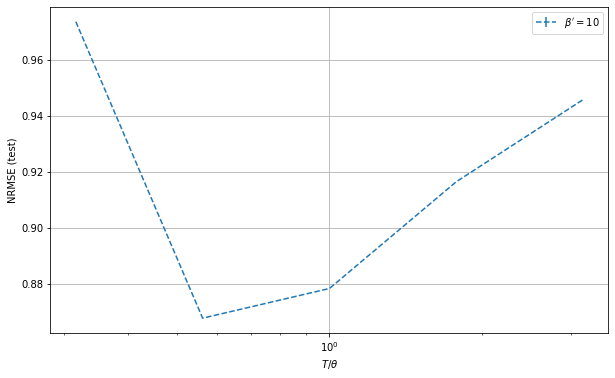

In [29]:
plt.figure(figsize=(10,6))
for i in range(len(bp_list)):
    bp = bp_list[i]
    plt.errorbar(T_theta_list,NRMSE_test_mean_vs_bp[i],NRMSE_test_std_vs_bp[i],linestyle = '--',label=r'$\beta^\prime = $'+str(bp))
plt.grid(True)
plt.legend(loc="best")
plt.xlabel(r'$T/\theta$')
plt.ylabel("NRMSE (test)")
plt.xscale("log")
plt.show()

### Role of nonlinearity ($m_0$)

In [30]:
bp_list = [10]
NL_list = np.logspace(-3,0,7)

Ntrain = 1000
Nvalid = 1000
Ntest = 500

Nv = 800
T_theta = .5
gamma = 0.

NRMSE_train_mean_vs_bp = []
NRMSE_valid_mean_vs_bp = []
NRMSE_test_mean_vs_bp = []
NRMSE_train_std_vs_bp = []
NRMSE_valid_std_vs_bp = []
NRMSE_test_std_vs_bp = []

for bp in bp_list:
    
    #m0_list
    (u,y) = NARMA10(Ntrain)
    spn = SPN.SP_Network(h,theta_H,k_s_0,phi,bp)
    f_m = spn.get_f_m_eq()
    dx = 5e-2
    fp0 = (f_m(dx/2)-f_m(-dx/2))/(dx)
    f_inf = f_m(1)
    U = max(u)-min(u)
    m0_list = NL_list*f_inf/(U*fp0)

    NRMSE_train_mean = []
    NRMSE_valid_mean = []
    NRMSE_test_mean = []
    NRMSE_train_std = []
    NRMSE_valid_std = []
    NRMSE_test_std = []

    N = 1

    for m0 in m0_list:
        print(m0)
        NRMSE_train = []
        NRMSE_valid = []
        NRMSE_test = []

        for i in range(N):
            
            (u,y) = NARMA10(Ntrain)
            (u_valid,y_valid) = NARMA10(Nvalid)
            (u_test,y_test) = NARMA10(Ntest)
            
            net = Single_Node_Reservoir_NARMA10(Nv,T_theta,m0,gamma,beta_prime=bp)

            S = net.gen_signal_fast(u)
            S_valid = net.gen_signal_fast(u_valid)
            S_test = net.gen_signal_fast(u_test)

            net.train(S,y,S_valid,y_valid)

            y_pred_train = net.predict(S)
            y_pred_valid = net.predict(S_valid)
            y_pred_test = net.predict(S_test)

            NRMSE_train.append(NRMSE_list(y,y_pred_train))
            NRMSE_valid.append(NRMSE_list(y_valid,y_pred_valid))
            NRMSE_test.append(NRMSE_list(y_test,y_pred_test))

        NRMSE_train_mean.append(np.mean(NRMSE_train))
        NRMSE_valid_mean.append(np.mean(NRMSE_valid))
        NRMSE_test_mean.append(np.mean(NRMSE_test))
        NRMSE_train_std.append(np.std(NRMSE_train,ddof=min(1,N-1)))
        NRMSE_valid_std.append(np.std(NRMSE_valid,ddof=min(1,N-1)))
        NRMSE_test_std.append(np.std(NRMSE_test,ddof=min(1,N-1)))
    
    NRMSE_train_mean_vs_bp.append(NRMSE_train_mean)
    NRMSE_valid_mean_vs_bp.append(NRMSE_valid_mean)
    NRMSE_test_mean_vs_bp.append(NRMSE_test_mean)
    NRMSE_train_std_vs_bp.append(NRMSE_train_std)
    NRMSE_valid_std_vs_bp.append(NRMSE_valid_std)
    NRMSE_test_std_vs_bp.append(NRMSE_test_std)

0.0005048965082409809
Use bias
0
100
200
300
400
500
600
700
800
900
1000
Use bias
0
100
200
300
400
500
600
700
800
900
1000
Use bias
0
100
200
300
400
500
alpha = 0.0 ; NRMSE (train) = 0.882 ; NRMSE (validation) = 0.864
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.882 ; NRMSE (validation) = 0.864
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.882 ; NRMSE (validation) = 0.864
alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.882 ; NRMSE (validation) = 0.864
alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.882 ; NRMSE (validation) = 0.864
alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.882 ; NRMSE (validation) = 0.864
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.882 ; NRMSE (validation) = 0.864
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.882 ; NRMSE (validation) = 0.864
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.882 ; NRMSE (validation) = 0.864
alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.882 ; NRMSE (validation) = 0.864
alpha = 7.847599703514623e-0

alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.862 ; NRMSE (validation) = 0.896
alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.862 ; NRMSE (validation) = 0.896
alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.862 ; NRMSE (validation) = 0.896
alpha = 4.832930238571752e-07 ; NRMSE (train) = 0.862 ; NRMSE (validation) = 0.895
alpha = 2.976351441631313e-06 ; NRMSE (train) = 0.863 ; NRMSE (validation) = 0.894
alpha = 1.8329807108324375e-05 ; NRMSE (train) = 0.864 ; NRMSE (validation) = 0.894
alpha = 0.00011288378916846884 ; NRMSE (train) = 0.864 ; NRMSE (validation) = 0.895
alpha = 0.000695192796177562 ; NRMSE (train) = 0.865 ; NRMSE (validation) = 0.896
alpha = 0.004281332398719396 ; NRMSE (train) = 0.876 ; NRMSE (validation) = 0.908
alpha = 0.026366508987303555 ; NRMSE (train) = 0.934 ; NRMSE (validation) = 0.968
alpha = 0.16237767391887242 ; NRMSE (train) = 0.983 ; NRMSE (validation) = 1.017
alpha = 1.0 ; NRMSE (train) = 0.995 ; NRMSE (validation) = 1.03
Optimal alpha = 2.97635144

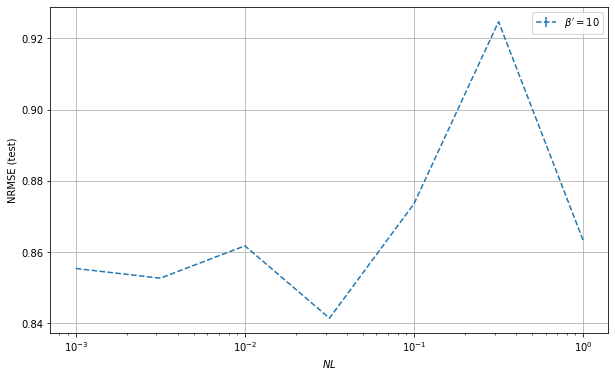

In [31]:
plt.figure(figsize=(10,6))
for i in range(len(bp_list)):
    bp = bp_list[i]
    plt.errorbar(NL_list,NRMSE_test_mean_vs_bp[i],NRMSE_test_std_vs_bp[i],linestyle = '--',label=r'$\beta^\prime = $'+str(bp))
plt.grid(True)
plt.legend(loc="best")
plt.xlabel(r'$NL$')
plt.ylabel("NRMSE (test)")
plt.xscale("log")
plt.show()

In [31]:
spn = SPN.SP_Network(h,theta_H,k_s_0,phi,10)
f_m = spn.get_f_m_eq()
dx = 5e-2
fp0 = (f_m(dx/2)-f_m(-dx/2))/(dx)
f_inf = f_m(1)
(u,y) = NARMA10(Ntrain)
U = max(u)-min(u)
print(0.005*U*fp0/f_inf)

0.009900328700184903


## Feedback

### Role of memory ($T/\theta$)

In [22]:
bp_list = [10]
T_theta_list = np.logspace(-2,1,7)

Ntrain = 1000
Nvalid = 1000
Ntest = 500

Nv = 800
m0 = 7e-2
gamma = 0.28

NRMSE_train_mean_vs_bp = []
NRMSE_valid_mean_vs_bp = []
NRMSE_test_mean_vs_bp = []
NRMSE_train_std_vs_bp = []
NRMSE_valid_std_vs_bp = []
NRMSE_test_std_vs_bp = []

for bp in bp_list:   

    NRMSE_train_mean = []
    NRMSE_valid_mean = []
    NRMSE_test_mean = []
    NRMSE_train_std = []
    NRMSE_valid_std = []
    NRMSE_test_std = []

    N = 1

    for T_theta in T_theta_list:
        print(T_theta)
        NRMSE_train = []
        NRMSE_valid = []
        NRMSE_test = []

        for i in range(N):
            (u,y) = NARMA10(Ntrain)
            (u_valid,y_valid) = NARMA10(Nvalid)
            (u_test,y_test) = NARMA10(Ntest)

            net = Single_Node_Reservoir_NARMA10(Nv,T_theta,m0,gamma,beta_prime=bp)

            S = net.gen_signal_fast_delayed_feedback(u,3)
            S_valid = net.gen_signal_fast_delayed_feedback(u_valid,3)
            S_test = net.gen_signal_fast_delayed_feedback(u_test,3)

            net.train(S,y,S_valid,y_valid)

            y_pred_train = net.predict(S)
            y_pred_valid = net.predict(S_valid)
            y_pred_test = net.predict(S_test)

            NRMSE_train.append(NRMSE_list(y,y_pred_train))
            NRMSE_valid.append(NRMSE_list(y_valid,y_pred_valid))
            NRMSE_test.append(NRMSE_list(y_test,y_pred_test))

        NRMSE_train_mean.append(np.mean(NRMSE_train))
        NRMSE_valid_mean.append(np.mean(NRMSE_valid))
        NRMSE_test_mean.append(np.mean(NRMSE_test))
        NRMSE_train_std.append(np.std(NRMSE_train,ddof=min(1,N-1)))
        NRMSE_valid_std.append(np.std(NRMSE_valid,ddof=min(1,N-1)))
        NRMSE_test_std.append(np.std(NRMSE_test,ddof=min(1,N-1)))
    
    NRMSE_train_mean_vs_bp.append(NRMSE_train_mean)
    NRMSE_valid_mean_vs_bp.append(NRMSE_valid_mean)
    NRMSE_test_mean_vs_bp.append(NRMSE_test_mean)
    NRMSE_train_std_vs_bp.append(NRMSE_train_std)
    NRMSE_valid_std_vs_bp.append(NRMSE_valid_std)
    NRMSE_test_std_vs_bp.append(NRMSE_test_std)

0.01
Use bias
0
100
200
300
400
500
600
700
800
900
1000
Use bias
0
100
200
300
400
500
600
700
800
900
1000
Use bias
0
100
200
300
400
500
alpha = 0.0 ; NRMSE (train) = 0.068 ; NRMSE (validation) = 0.343
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.068 ; NRMSE (validation) = 0.343
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.068 ; NRMSE (validation) = 0.343
alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.068 ; NRMSE (validation) = 0.343
alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.068 ; NRMSE (validation) = 0.343
alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.068 ; NRMSE (validation) = 0.343
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.068 ; NRMSE (validation) = 0.343
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.068 ; NRMSE (validation) = 0.343
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.068 ; NRMSE (validation) = 0.343
alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.068 ; NRMSE (validation) = 0.343
alpha = 7.847599703514623e-08 ; NRMSE (train)

alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.082 ; NRMSE (validation) = 0.438
alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.093 ; NRMSE (validation) = 0.406
alpha = 4.832930238571752e-07 ; NRMSE (train) = 0.12 ; NRMSE (validation) = 0.386
alpha = 2.976351441631313e-06 ; NRMSE (train) = 0.162 ; NRMSE (validation) = 0.389
alpha = 1.8329807108324375e-05 ; NRMSE (train) = 0.209 ; NRMSE (validation) = 0.41
alpha = 0.00011288378916846884 ; NRMSE (train) = 0.255 ; NRMSE (validation) = 0.439
alpha = 0.000695192796177562 ; NRMSE (train) = 0.303 ; NRMSE (validation) = 0.47
alpha = 0.004281332398719396 ; NRMSE (train) = 0.338 ; NRMSE (validation) = 0.495
alpha = 0.026366508987303555 ; NRMSE (train) = 0.352 ; NRMSE (validation) = 0.506
alpha = 0.16237767391887242 ; NRMSE (train) = 0.364 ; NRMSE (validation) = 0.518
alpha = 1.0 ; NRMSE (train) = 0.4 ; NRMSE (validation) = 0.554
Optimal alpha = 4.832930238571752e-07 with NRMSE (validation) = 0.3862913773782483
3.1622776601683795
Use bias
0

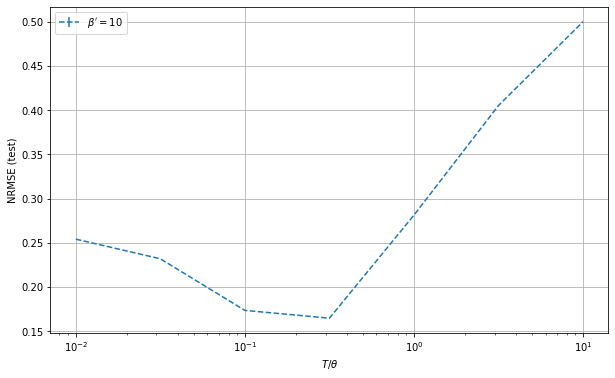

In [23]:
plt.figure(figsize=(10,6))
for i in range(len(bp_list)):
    bp = bp_list[i]
    plt.errorbar(T_theta_list,NRMSE_test_mean_vs_bp[i],NRMSE_test_std_vs_bp[i],linestyle = '--',label=r'$\beta^\prime = $'+str(bp))
plt.grid(True)
plt.legend(loc="best")
plt.xlabel(r'$T/\theta$')
plt.ylabel("NRMSE (test)")
plt.xscale("log")
plt.show()

### Role of nonlinearity ($m_0$)

In [38]:
bp_list = [10,30]
NL_list = np.logspace(-2,0,7)

Ntrain = 1000
Nvalid = 1000
Ntest = 500

Nv = 800
T_theta = .3
gamma_fp0 = 0.9

NRMSE_train_mean_vs_bp = []
NRMSE_valid_mean_vs_bp = []
NRMSE_test_mean_vs_bp = []
NRMSE_train_std_vs_bp = []
NRMSE_valid_std_vs_bp = []
NRMSE_test_std_vs_bp = []

for bp in bp_list:
    
    #m0_list and gamma
    (u,y) = NARMA10(Ntrain)
    spn = SPN.SP_Network(h,theta_H,k_s_0,phi,bp)
    f_m = spn.get_f_m_eq()
    dx = 5e-2
    fp0 = (f_m(dx/2)-f_m(-dx/2))/(dx)
    f_inf = f_m(1)
    U = max(u)-min(u)
    m0_list = NL_list*f_inf/(U*fp0)
    gamma = gamma_fp0/fp0

    NRMSE_train_mean = []
    NRMSE_valid_mean = []
    NRMSE_test_mean = []
    NRMSE_train_std = []
    NRMSE_valid_std = []
    NRMSE_test_std = []

    N = 1

    for m0 in m0_list:
        print(m0)
        NRMSE_train = []
        NRMSE_valid = []
        NRMSE_test = []

        for i in range(N):
            
            (u,y) = NARMA10(Ntrain)
            (u_valid,y_valid) = NARMA10(Nvalid)
            (u_test,y_test) = NARMA10(Ntest)
            
            net = Single_Node_Reservoir_NARMA10(Nv,T_theta,m0,gamma,beta_prime=bp)

            S = net.gen_signal_fast_delayed_feedback(u,1)
            S_valid = net.gen_signal_fast_delayed_feedback(u_valid,1)
            S_test = net.gen_signal_fast_delayed_feedback(u_test,1)
            net.train(S,y,S_valid,y_valid)

            y_pred_train = net.predict(S)
            y_pred_valid = net.predict(S_valid)
            y_pred_test = net.predict(S_test)

            NRMSE_train.append(NRMSE_list(y,y_pred_train))
            NRMSE_valid.append(NRMSE_list(y_valid,y_pred_valid))
            NRMSE_test.append(NRMSE_list(y_test,y_pred_test))

        NRMSE_train_mean.append(np.mean(NRMSE_train))
        NRMSE_valid_mean.append(np.mean(NRMSE_valid))
        NRMSE_test_mean.append(np.mean(NRMSE_test))
        NRMSE_train_std.append(np.std(NRMSE_train,ddof=min(1,N-1)))
        NRMSE_valid_std.append(np.std(NRMSE_valid,ddof=min(1,N-1)))
        NRMSE_test_std.append(np.std(NRMSE_test,ddof=min(1,N-1)))
    
    NRMSE_train_mean_vs_bp.append(NRMSE_train_mean)
    NRMSE_valid_mean_vs_bp.append(NRMSE_valid_mean)
    NRMSE_test_mean_vs_bp.append(NRMSE_test_mean)
    NRMSE_train_std_vs_bp.append(NRMSE_train_std)
    NRMSE_valid_std_vs_bp.append(NRMSE_valid_std)
    NRMSE_test_std_vs_bp.append(NRMSE_test_std)

0.0050536104215925266
Use bias
0
100
200
300
400
500
600
700
800
900
1000
Use bias
0
100
200
300
400
500
600
700
800
900
1000
Use bias
0
100
200
300
400
500
alpha = 0.0 ; NRMSE (train) = 0.081 ; NRMSE (validation) = 0.433
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.081 ; NRMSE (validation) = 0.432
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.081 ; NRMSE (validation) = 0.431
alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.08 ; NRMSE (validation) = 0.415
alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.081 ; NRMSE (validation) = 0.376
alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.094 ; NRMSE (validation) = 0.313
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.13 ; NRMSE (validation) = 0.283
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.199 ; NRMSE (validation) = 0.316
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.278 ; NRMSE (validation) = 0.376
alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.328 ; NRMSE (validation) = 0.41
alpha = 7.847599703514623e-08 ;

alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.06 ; NRMSE (validation) = 0.347
alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.06 ; NRMSE (validation) = 0.347
alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.06 ; NRMSE (validation) = 0.346
alpha = 4.832930238571752e-07 ; NRMSE (train) = 0.06 ; NRMSE (validation) = 0.343
alpha = 2.976351441631313e-06 ; NRMSE (train) = 0.061 ; NRMSE (validation) = 0.328
alpha = 1.8329807108324375e-05 ; NRMSE (train) = 0.063 ; NRMSE (validation) = 0.288
alpha = 0.00011288378916846884 ; NRMSE (train) = 0.073 ; NRMSE (validation) = 0.242
alpha = 0.000695192796177562 ; NRMSE (train) = 0.094 ; NRMSE (validation) = 0.214
alpha = 0.004281332398719396 ; NRMSE (train) = 0.139 ; NRMSE (validation) = 0.224
alpha = 0.026366508987303555 ; NRMSE (train) = 0.232 ; NRMSE (validation) = 0.305
alpha = 0.16237767391887242 ; NRMSE (train) = 0.347 ; NRMSE (validation) = 0.401
alpha = 1.0 ; NRMSE (train) = 0.411 ; NRMSE (validation) = 0.447
Optimal alpha = 0.00069519279

alpha = 0.16237767391887242 ; NRMSE (train) = 0.37 ; NRMSE (validation) = 0.389
alpha = 1.0 ; NRMSE (train) = 0.429 ; NRMSE (validation) = 0.439
Optimal alpha = 3.3598182862837877e-10 with NRMSE (validation) = 0.3328764106525955
0.007832626087036334
Use bias
0
100
200
300
400
500
600
700
800
900
1000
Use bias
0
100
200
300
400
500
600
700
800
900
1000
Use bias
0
100
200
300
400
500
alpha = 0.0 ; NRMSE (train) = 0.118 ; NRMSE (validation) = 0.655
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.118 ; NRMSE (validation) = 0.655
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.118 ; NRMSE (validation) = 0.655
alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.118 ; NRMSE (validation) = 0.655
alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.118 ; NRMSE (validation) = 0.655
alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.118 ; NRMSE (validation) = 0.655
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.118 ; NRMSE (validation) = 0.654
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0

alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.219 ; NRMSE (validation) = 1.608
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.219 ; NRMSE (validation) = 1.608
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.219 ; NRMSE (validation) = 1.608
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.219 ; NRMSE (validation) = 1.605
alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.219 ; NRMSE (validation) = 1.59
alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.219 ; NRMSE (validation) = 1.529
alpha = 4.832930238571752e-07 ; NRMSE (train) = 0.222 ; NRMSE (validation) = 1.38
alpha = 2.976351441631313e-06 ; NRMSE (train) = 0.229 ; NRMSE (validation) = 1.167
alpha = 1.8329807108324375e-05 ; NRMSE (train) = 0.243 ; NRMSE (validation) = 0.949
alpha = 0.00011288378916846884 ; NRMSE (train) = 0.265 ; NRMSE (validation) = 0.784
alpha = 0.000695192796177562 ; NRMSE (train) = 0.297 ; NRMSE (validation) = 0.654
alpha = 0.004281332398719396 ; NRMSE (train) = 0.343 ; NRMSE (validation) = 0.578
alph

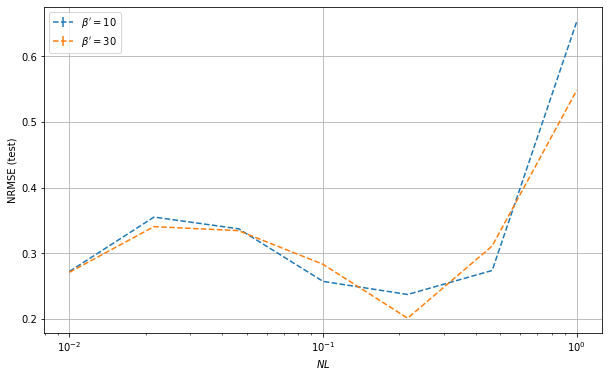

In [39]:
plt.figure(figsize=(10,6))
for i in range(len(bp_list)):
    bp = bp_list[i]
    plt.errorbar(NL_list,NRMSE_test_mean_vs_bp[i],NRMSE_test_std_vs_bp[i],linestyle = '--',label=r'$\beta^\prime = $'+str(bp))
plt.grid(True)
plt.legend(loc="best")
plt.xlabel(r'$NL$')
plt.ylabel("NRMSE (test)")
plt.xscale("log")
plt.show()

In [49]:
bp_list = [10,30]
gamma_fp0_list = np.linspace(.7,0.95,10)

Ntrain = 1000
Nvalid = 1000
Ntest = 500

Nv = 800
T_theta = .3
NL = 3e-1

NRMSE_train_mean_vs_bp = []
NRMSE_valid_mean_vs_bp = []
NRMSE_test_mean_vs_bp = []
NRMSE_train_std_vs_bp = []
NRMSE_valid_std_vs_bp = []
NRMSE_test_std_vs_bp = []

for bp in bp_list:
    
    #gamma_list and m0
    (u,y) = NARMA10(Ntrain)
    spn = SPN.SP_Network(h,theta_H,k_s_0,phi,bp)
    f_m = spn.get_f_m_eq()
    dx = 5e-2
    fp0 = (f_m(dx/2)-f_m(-dx/2))/(dx)
    f_inf = f_m(1)
    U = max(u)-min(u)
    m0 = NL*f_inf/(U*fp0)
    gamma_list = gamma_fp0_list/fp0

    NRMSE_train_mean = []
    NRMSE_valid_mean = []
    NRMSE_test_mean = []
    NRMSE_train_std = []
    NRMSE_valid_std = []
    NRMSE_test_std = []

    N = 5

    for gamma in gamma_list:
        print(gamma)
        NRMSE_train = []
        NRMSE_valid = []
        NRMSE_test = []

        for i in range(N):
            
            (u,y) = NARMA10(Ntrain)
            (u_valid,y_valid) = NARMA10(Nvalid)
            (u_test,y_test) = NARMA10(Ntest)
            
            net = Single_Node_Reservoir_NARMA10(Nv,T_theta,m0,gamma,beta_prime=bp)

            S = net.gen_signal_fast_delayed_feedback(u,1)
            S_valid = net.gen_signal_fast_delayed_feedback(u_valid,1)
            S_test = net.gen_signal_fast_delayed_feedback(u_test,1)
            net.train(S,y,S_valid,y_valid)

            y_pred_train = net.predict(S)
            y_pred_valid = net.predict(S_valid)
            y_pred_test = net.predict(S_test)

            NRMSE_train.append(NRMSE_list(y,y_pred_train))
            NRMSE_valid.append(NRMSE_list(y_valid,y_pred_valid))
            NRMSE_test.append(NRMSE_list(y_test,y_pred_test))

        NRMSE_train_mean.append(np.mean(NRMSE_train))
        NRMSE_valid_mean.append(np.mean(NRMSE_valid))
        NRMSE_test_mean.append(np.mean(NRMSE_test))
        NRMSE_train_std.append(np.std(NRMSE_train,ddof=min(1,N-1)))
        NRMSE_valid_std.append(np.std(NRMSE_valid,ddof=min(1,N-1)))
        NRMSE_test_std.append(np.std(NRMSE_test,ddof=min(1,N-1)))
    
    NRMSE_train_mean_vs_bp.append(NRMSE_train_mean)
    NRMSE_valid_mean_vs_bp.append(NRMSE_valid_mean)
    NRMSE_test_mean_vs_bp.append(NRMSE_test_mean)
    NRMSE_train_std_vs_bp.append(NRMSE_train_std)
    NRMSE_valid_std_vs_bp.append(NRMSE_valid_std)
    NRMSE_test_std_vs_bp.append(NRMSE_test_std)

0.21981771332043035
Use bias
0
100
200
300
400
500
600
700
800
900
1000
Use bias
0
100
200
300
400
500
600
700
800
900
1000
Use bias
0
100
200
300
400
500
alpha = 0.0 ; NRMSE (train) = 0.084 ; NRMSE (validation) = 0.436
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.084 ; NRMSE (validation) = 0.436
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.084 ; NRMSE (validation) = 0.436
alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.084 ; NRMSE (validation) = 0.436
alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.084 ; NRMSE (validation) = 0.436
alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.084 ; NRMSE (validation) = 0.436
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.084 ; NRMSE (validation) = 0.436
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.084 ; NRMSE (validation) = 0.435
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.084 ; NRMSE (validation) = 0.43
alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.084 ; NRMSE (validation) = 0.405
alpha = 7.847599703514623e-08 ;

alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.092 ; NRMSE (validation) = 0.41
alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.097 ; NRMSE (validation) = 0.353
alpha = 4.832930238571752e-07 ; NRMSE (train) = 0.113 ; NRMSE (validation) = 0.295
alpha = 2.976351441631313e-06 ; NRMSE (train) = 0.143 ; NRMSE (validation) = 0.259
alpha = 1.8329807108324375e-05 ; NRMSE (train) = 0.188 ; NRMSE (validation) = 0.249
alpha = 0.00011288378916846884 ; NRMSE (train) = 0.25 ; NRMSE (validation) = 0.281
alpha = 0.000695192796177562 ; NRMSE (train) = 0.331 ; NRMSE (validation) = 0.36
alpha = 0.004281332398719396 ; NRMSE (train) = 0.403 ; NRMSE (validation) = 0.434
alpha = 0.026366508987303555 ; NRMSE (train) = 0.442 ; NRMSE (validation) = 0.463
alpha = 0.16237767391887242 ; NRMSE (train) = 0.49 ; NRMSE (validation) = 0.498
alpha = 1.0 ; NRMSE (train) = 0.626 ; NRMSE (validation) = 0.633
Optimal alpha = 1.8329807108324375e-05 with NRMSE (validation) = 0.2499148644492378
0.22854063845219344
Use bia

Use bias
0
100
200
300
400
500
600
700
800
900
1000
Use bias
0
100
200
300
400
500
600
700
800
900
1000
Use bias
0
100
200
300
400
500
alpha = 0.0 ; NRMSE (train) = 0.064 ; NRMSE (validation) = 0.38
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.064 ; NRMSE (validation) = 0.38
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.064 ; NRMSE (validation) = 0.38
alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.064 ; NRMSE (validation) = 0.38
alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.064 ; NRMSE (validation) = 0.38
alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.064 ; NRMSE (validation) = 0.38
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.064 ; NRMSE (validation) = 0.379
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.064 ; NRMSE (validation) = 0.379
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.064 ; NRMSE (validation) = 0.377
alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.064 ; NRMSE (validation) = 0.365
alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.067 ; 

alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.077 ; NRMSE (validation) = 0.432
alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.077 ; NRMSE (validation) = 0.401
alpha = 4.832930238571752e-07 ; NRMSE (train) = 0.081 ; NRMSE (validation) = 0.342
alpha = 2.976351441631313e-06 ; NRMSE (train) = 0.095 ; NRMSE (validation) = 0.285
alpha = 1.8329807108324375e-05 ; NRMSE (train) = 0.123 ; NRMSE (validation) = 0.248
alpha = 0.00011288378916846884 ; NRMSE (train) = 0.17 ; NRMSE (validation) = 0.25
alpha = 0.000695192796177562 ; NRMSE (train) = 0.237 ; NRMSE (validation) = 0.294
alpha = 0.004281332398719396 ; NRMSE (train) = 0.324 ; NRMSE (validation) = 0.367
alpha = 0.026366508987303555 ; NRMSE (train) = 0.397 ; NRMSE (validation) = 0.424
alpha = 0.16237767391887242 ; NRMSE (train) = 0.439 ; NRMSE (validation) = 0.455
alpha = 1.0 ; NRMSE (train) = 0.505 ; NRMSE (validation) = 0.516
Optimal alpha = 1.8329807108324375e-05 with NRMSE (validation) = 0.2480473513818049
Use bias
0
100
200
300
40

alpha = 1.0 ; NRMSE (train) = 0.511 ; NRMSE (validation) = 0.548
Optimal alpha = 0.00011288378916846884 with NRMSE (validation) = 0.3049972735291872
Use bias
0
100
200
300
400
500
600
700
800
900
1000
Use bias
0
100
200
300
400
500
600
700
800
900
1000
Use bias
0
100
200
300
400
500
alpha = 0.0 ; NRMSE (train) = 0.076 ; NRMSE (validation) = 0.394
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.076 ; NRMSE (validation) = 0.394
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.076 ; NRMSE (validation) = 0.394
alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.076 ; NRMSE (validation) = 0.394
alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.076 ; NRMSE (validation) = 0.394
alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.076 ; NRMSE (validation) = 0.394
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.076 ; NRMSE (validation) = 0.394
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.076 ; NRMSE (validation) = 0.394
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.076 ; NRMSE (valid

alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.091 ; NRMSE (validation) = 0.474
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.091 ; NRMSE (validation) = 0.474
alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.091 ; NRMSE (validation) = 0.471
alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.091 ; NRMSE (validation) = 0.459
alpha = 4.832930238571752e-07 ; NRMSE (train) = 0.092 ; NRMSE (validation) = 0.411
alpha = 2.976351441631313e-06 ; NRMSE (train) = 0.098 ; NRMSE (validation) = 0.33
alpha = 1.8329807108324375e-05 ; NRMSE (train) = 0.115 ; NRMSE (validation) = 0.262
alpha = 0.00011288378916846884 ; NRMSE (train) = 0.148 ; NRMSE (validation) = 0.223
alpha = 0.000695192796177562 ; NRMSE (train) = 0.194 ; NRMSE (validation) = 0.219
alpha = 0.004281332398719396 ; NRMSE (train) = 0.264 ; NRMSE (validation) = 0.261
alpha = 0.026366508987303555 ; NRMSE (train) = 0.361 ; NRMSE (validation) = 0.358
alpha = 0.16237767391887242 ; NRMSE (train) = 0.43 ; NRMSE (validation) = 0.42
alpha = 1

alpha = 0.026366508987303555 ; NRMSE (train) = 0.325 ; NRMSE (validation) = 0.302
alpha = 0.16237767391887242 ; NRMSE (train) = 0.435 ; NRMSE (validation) = 0.405
alpha = 1.0 ; NRMSE (train) = 0.491 ; NRMSE (validation) = 0.444
Optimal alpha = 0.000695192796177562 with NRMSE (validation) = 0.18825163412606047
Use bias
0
100
200
300
400
500
600
700
800
900
1000
Use bias
0
100
200
300
400
500
600
700
800
900
1000
Use bias
0
100
200
300
400
500
alpha = 0.0 ; NRMSE (train) = 0.055 ; NRMSE (validation) = 0.322
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.055 ; NRMSE (validation) = 0.322
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.055 ; NRMSE (validation) = 0.322
alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.055 ; NRMSE (validation) = 0.322
alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.055 ; NRMSE (validation) = 0.322
alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.055 ; NRMSE (validation) = 0.322
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.055 ; NRMSE (validatio

alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.056 ; NRMSE (validation) = 0.387
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.056 ; NRMSE (validation) = 0.387
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.056 ; NRMSE (validation) = 0.387
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.056 ; NRMSE (validation) = 0.387
alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.056 ; NRMSE (validation) = 0.387
alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.056 ; NRMSE (validation) = 0.387
alpha = 4.832930238571752e-07 ; NRMSE (train) = 0.056 ; NRMSE (validation) = 0.383
alpha = 2.976351441631313e-06 ; NRMSE (train) = 0.057 ; NRMSE (validation) = 0.371
alpha = 1.8329807108324375e-05 ; NRMSE (train) = 0.06 ; NRMSE (validation) = 0.351
alpha = 0.00011288378916846884 ; NRMSE (train) = 0.073 ; NRMSE (validation) = 0.342
alpha = 0.000695192796177562 ; NRMSE (train) = 0.1 ; NRMSE (validation) = 0.353
alpha = 0.004281332398719396 ; NRMSE (train) = 0.15 ; NRMSE (validation) = 0.389
alpha 

alpha = 0.004281332398719396 ; NRMSE (train) = 0.127 ; NRMSE (validation) = 0.322
alpha = 0.026366508987303555 ; NRMSE (train) = 0.204 ; NRMSE (validation) = 0.364
alpha = 0.16237767391887242 ; NRMSE (train) = 0.33 ; NRMSE (validation) = 0.451
alpha = 1.0 ; NRMSE (train) = 0.438 ; NRMSE (validation) = 0.525
Optimal alpha = 0.004281332398719396 with NRMSE (validation) = 0.32275048762028974
Use bias
0
100
200
300
400
500
600
700
800
900
1000
Use bias
0
100
200
300
400
500
600
700
800
900
1000
Use bias
0
100
200
300
400
500
alpha = 0.0 ; NRMSE (train) = 0.064 ; NRMSE (validation) = 0.37
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.064 ; NRMSE (validation) = 0.37
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.064 ; NRMSE (validation) = 0.37
alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.064 ; NRMSE (validation) = 0.37
alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.064 ; NRMSE (validation) = 0.37
alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.064 ; NRMSE (validation) = 0.3

alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.073 ; NRMSE (validation) = 0.394
alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.073 ; NRMSE (validation) = 0.394
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.073 ; NRMSE (validation) = 0.394
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.073 ; NRMSE (validation) = 0.394
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.073 ; NRMSE (validation) = 0.394
alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.073 ; NRMSE (validation) = 0.394
alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.073 ; NRMSE (validation) = 0.393
alpha = 4.832930238571752e-07 ; NRMSE (train) = 0.073 ; NRMSE (validation) = 0.392
alpha = 2.976351441631313e-06 ; NRMSE (train) = 0.073 ; NRMSE (validation) = 0.386
alpha = 1.8329807108324375e-05 ; NRMSE (train) = 0.074 ; NRMSE (validation) = 0.363
alpha = 0.00011288378916846884 ; NRMSE (train) = 0.079 ; NRMSE (validation) = 0.321
alpha = 0.000695192796177562 ; NRMSE (train) = 0.093 ; NRMSE (validation) = 0.278
a

alpha = 0.000695192796177562 ; NRMSE (train) = 0.097 ; NRMSE (validation) = 0.293
alpha = 0.004281332398719396 ; NRMSE (train) = 0.124 ; NRMSE (validation) = 0.262
alpha = 0.026366508987303555 ; NRMSE (train) = 0.175 ; NRMSE (validation) = 0.268
alpha = 0.16237767391887242 ; NRMSE (train) = 0.277 ; NRMSE (validation) = 0.341
alpha = 1.0 ; NRMSE (train) = 0.396 ; NRMSE (validation) = 0.433
Optimal alpha = 0.004281332398719396 with NRMSE (validation) = 0.26286476646317714
0.2983240395062983
Use bias
0
100
200
300
400
500
600
700
800
900
1000
Use bias
0
100
200
300
400
500
600
700
800
900
1000
Use bias
0
100
200
300
400
500
alpha = 0.0 ; NRMSE (train) = 0.083 ; NRMSE (validation) = 0.462
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.083 ; NRMSE (validation) = 0.462
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.083 ; NRMSE (validation) = 0.462
alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.083 ; NRMSE (validation) = 0.462
alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.083 ; 

alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.076 ; NRMSE (validation) = 0.447
alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.076 ; NRMSE (validation) = 0.447
alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.076 ; NRMSE (validation) = 0.447
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.076 ; NRMSE (validation) = 0.447
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.076 ; NRMSE (validation) = 0.447
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.076 ; NRMSE (validation) = 0.447
alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.076 ; NRMSE (validation) = 0.447
alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.076 ; NRMSE (validation) = 0.447
alpha = 4.832930238571752e-07 ; NRMSE (train) = 0.076 ; NRMSE (validation) = 0.446
alpha = 2.976351441631313e-06 ; NRMSE (train) = 0.076 ; NRMSE (validation) = 0.444
alpha = 1.8329807108324375e-05 ; NRMSE (train) = 0.077 ; NRMSE (validation) = 0.432
alpha = 0.00011288378916846884 ; NRMSE (train) = 0.078 ; NRMSE (validation) = 0.392


alpha = 0.00011288378916846884 ; NRMSE (train) = 0.265 ; NRMSE (validation) = 0.422
alpha = 0.000695192796177562 ; NRMSE (train) = 0.335 ; NRMSE (validation) = 0.424
alpha = 0.004281332398719396 ; NRMSE (train) = 0.422 ; NRMSE (validation) = 0.464
alpha = 0.026366508987303555 ; NRMSE (train) = 0.478 ; NRMSE (validation) = 0.485
alpha = 0.16237767391887242 ; NRMSE (train) = 0.517 ; NRMSE (validation) = 0.499
alpha = 1.0 ; NRMSE (train) = 0.604 ; NRMSE (validation) = 0.589
Optimal alpha = 0.00011288378916846884 with NRMSE (validation) = 0.42269067016085277
Use bias
0
100
200
300
400
500
600
700
800
900
1000
Use bias
0
100
200
300
400
500
600
700
800
900
1000
Use bias
0
100
200
300
400
500
alpha = 0.0 ; NRMSE (train) = 0.105 ; NRMSE (validation) = 0.55
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.105 ; NRMSE (validation) = 0.55
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.105 ; NRMSE (validation) = 0.55
alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.105 ; NRMSE (validation) 

alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.091 ; NRMSE (validation) = 0.663
alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.091 ; NRMSE (validation) = 0.663
alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.091 ; NRMSE (validation) = 0.663
alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.091 ; NRMSE (validation) = 0.663
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.091 ; NRMSE (validation) = 0.663
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.091 ; NRMSE (validation) = 0.663
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.091 ; NRMSE (validation) = 0.663
alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.091 ; NRMSE (validation) = 0.66
alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.092 ; NRMSE (validation) = 0.648
alpha = 4.832930238571752e-07 ; NRMSE (train) = 0.095 ; NRMSE (validation) = 0.616
alpha = 2.976351441631313e-06 ; NRMSE (train) = 0.11 ; NRMSE (validation) = 0.582
alpha = 1.8329807108324375e-05 ; NRMSE (train) = 0.137 ; NRMSE (validation) = 0.568
al

alpha = 1.8329807108324375e-05 ; NRMSE (train) = 0.136 ; NRMSE (validation) = 0.373
alpha = 0.00011288378916846884 ; NRMSE (train) = 0.175 ; NRMSE (validation) = 0.327
alpha = 0.000695192796177562 ; NRMSE (train) = 0.231 ; NRMSE (validation) = 0.331
alpha = 0.004281332398719396 ; NRMSE (train) = 0.314 ; NRMSE (validation) = 0.376
alpha = 0.026366508987303555 ; NRMSE (train) = 0.396 ; NRMSE (validation) = 0.432
alpha = 0.16237767391887242 ; NRMSE (train) = 0.44 ; NRMSE (validation) = 0.463
alpha = 1.0 ; NRMSE (train) = 0.485 ; NRMSE (validation) = 0.503
Optimal alpha = 0.00011288378916846884 with NRMSE (validation) = 0.3279849966507475
Use bias
0
100
200
300
400
500
600
700
800
900
1000
Use bias
0
100
200
300
400
500
600
700
800
900
1000
Use bias
0
100
200
300
400
500
alpha = 0.0 ; NRMSE (train) = 0.092 ; NRMSE (validation) = 0.541
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.092 ; NRMSE (validation) = 0.541
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.092 ; NRMSE (validation

alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.08 ; NRMSE (validation) = 0.492
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.08 ; NRMSE (validation) = 0.492
alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.08 ; NRMSE (validation) = 0.492
alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.08 ; NRMSE (validation) = 0.492
alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.08 ; NRMSE (validation) = 0.492
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.08 ; NRMSE (validation) = 0.492
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.08 ; NRMSE (validation) = 0.492
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.08 ; NRMSE (validation) = 0.492
alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.08 ; NRMSE (validation) = 0.491
alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.08 ; NRMSE (validation) = 0.485
alpha = 4.832930238571752e-07 ; NRMSE (train) = 0.081 ; NRMSE (validation) = 0.46
alpha = 2.976351441631313e-06 ; NRMSE (train) = 0.084 ; NRMSE (validation) = 0.403
alpha = 1.83

alpha = 2.976351441631313e-06 ; NRMSE (train) = 0.101 ; NRMSE (validation) = 0.583
alpha = 1.8329807108324375e-05 ; NRMSE (train) = 0.108 ; NRMSE (validation) = 0.473
alpha = 0.00011288378916846884 ; NRMSE (train) = 0.131 ; NRMSE (validation) = 0.367
alpha = 0.000695192796177562 ; NRMSE (train) = 0.172 ; NRMSE (validation) = 0.314
alpha = 0.004281332398719396 ; NRMSE (train) = 0.234 ; NRMSE (validation) = 0.32
alpha = 0.026366508987303555 ; NRMSE (train) = 0.323 ; NRMSE (validation) = 0.392
alpha = 0.16237767391887242 ; NRMSE (train) = 0.406 ; NRMSE (validation) = 0.471
alpha = 1.0 ; NRMSE (train) = 0.452 ; NRMSE (validation) = 0.509
Optimal alpha = 0.000695192796177562 with NRMSE (validation) = 0.31474080000581556
Use bias
0
100
200
300
400
500
600
700
800
900
1000
Use bias
0
100
200
300
400
500
600
700
800
900
1000
Use bias
0
100
200
300
400
500
alpha = 0.0 ; NRMSE (train) = 0.101 ; NRMSE (validation) = 0.582
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.101 ; NRMSE (validation) 

900
1000
Use bias
0
100
200
300
400
500
alpha = 0.0 ; NRMSE (train) = 0.09 ; NRMSE (validation) = 0.723
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.09 ; NRMSE (validation) = 0.723
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.09 ; NRMSE (validation) = 0.723
alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.09 ; NRMSE (validation) = 0.723
alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.09 ; NRMSE (validation) = 0.723
alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.09 ; NRMSE (validation) = 0.723
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.09 ; NRMSE (validation) = 0.723
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.09 ; NRMSE (validation) = 0.723
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.09 ; NRMSE (validation) = 0.723
alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.09 ; NRMSE (validation) = 0.723
alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.09 ; NRMSE (validation) = 0.723
alpha = 4.832930238571752e-07 ; NRMSE (train) = 0.09 ; NRMSE (validation)

alpha = 4.832930238571752e-07 ; NRMSE (train) = 0.1 ; NRMSE (validation) = 0.483
alpha = 2.976351441631313e-06 ; NRMSE (train) = 0.1 ; NRMSE (validation) = 0.472
alpha = 1.8329807108324375e-05 ; NRMSE (train) = 0.101 ; NRMSE (validation) = 0.427
alpha = 0.00011288378916846884 ; NRMSE (train) = 0.108 ; NRMSE (validation) = 0.344
alpha = 0.000695192796177562 ; NRMSE (train) = 0.128 ; NRMSE (validation) = 0.267
alpha = 0.004281332398719396 ; NRMSE (train) = 0.168 ; NRMSE (validation) = 0.234
alpha = 0.026366508987303555 ; NRMSE (train) = 0.243 ; NRMSE (validation) = 0.281
alpha = 0.16237767391887242 ; NRMSE (train) = 0.347 ; NRMSE (validation) = 0.377
alpha = 1.0 ; NRMSE (train) = 0.415 ; NRMSE (validation) = 0.429
Optimal alpha = 0.004281332398719396 with NRMSE (validation) = 0.2347635432358607
Use bias
0
100
200
300
400
500
600
700
800
900
1000
Use bias
0
100
200
300
400
500
600
700
800
900
1000
Use bias
0
100
200
300
400
500
alpha = 0.0 ; NRMSE (train) = 0.092 ; NRMSE (validation) = 0.

100
200
300
400
500
600
700
800
900
1000
Use bias
0
100
200
300
400
500
600
700
800
900
1000
Use bias
0
100
200
300
400
500
alpha = 0.0 ; NRMSE (train) = 0.075 ; NRMSE (validation) = 0.396
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.075 ; NRMSE (validation) = 0.396
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.075 ; NRMSE (validation) = 0.396
alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.075 ; NRMSE (validation) = 0.396
alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.075 ; NRMSE (validation) = 0.396
alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.075 ; NRMSE (validation) = 0.396
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.075 ; NRMSE (validation) = 0.396
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.075 ; NRMSE (validation) = 0.396
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.075 ; NRMSE (validation) = 0.396
alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.075 ; NRMSE (validation) = 0.396
alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.075 ; NRMSE

alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.073 ; NRMSE (validation) = 0.402
alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.073 ; NRMSE (validation) = 0.402
alpha = 4.832930238571752e-07 ; NRMSE (train) = 0.073 ; NRMSE (validation) = 0.401
alpha = 2.976351441631313e-06 ; NRMSE (train) = 0.073 ; NRMSE (validation) = 0.397
alpha = 1.8329807108324375e-05 ; NRMSE (train) = 0.073 ; NRMSE (validation) = 0.377
alpha = 0.00011288378916846884 ; NRMSE (train) = 0.076 ; NRMSE (validation) = 0.327
alpha = 0.000695192796177562 ; NRMSE (train) = 0.089 ; NRMSE (validation) = 0.272
alpha = 0.004281332398719396 ; NRMSE (train) = 0.118 ; NRMSE (validation) = 0.237
alpha = 0.026366508987303555 ; NRMSE (train) = 0.174 ; NRMSE (validation) = 0.249
alpha = 0.16237767391887242 ; NRMSE (train) = 0.279 ; NRMSE (validation) = 0.33
alpha = 1.0 ; NRMSE (train) = 0.381 ; NRMSE (validation) = 0.413
Optimal alpha = 0.004281332398719396 with NRMSE (validation) = 0.23781960185615342
0.09614424528908369
Use b

alpha = 1.0 ; NRMSE (train) = 0.364 ; NRMSE (validation) = 0.428
Optimal alpha = 0.026366508987303555 with NRMSE (validation) = 0.2710373192509743
Use bias
0
100
200
300
400
500
600
700
800
900
1000
Use bias
0
100
200
300
400
500
600
700
800
900
1000
Use bias
0
100
200
300
400
500
alpha = 0.0 ; NRMSE (train) = 0.08 ; NRMSE (validation) = 0.397
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.08 ; NRMSE (validation) = 0.397
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.08 ; NRMSE (validation) = 0.397
alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.08 ; NRMSE (validation) = 0.397
alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.08 ; NRMSE (validation) = 0.397
alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.08 ; NRMSE (validation) = 0.397
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.08 ; NRMSE (validation) = 0.397
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.08 ; NRMSE (validation) = 0.397
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.08 ; NRMSE (validation) = 0.

alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.082 ; NRMSE (validation) = 0.453
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.082 ; NRMSE (validation) = 0.453
alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.082 ; NRMSE (validation) = 0.453
alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.082 ; NRMSE (validation) = 0.453
alpha = 4.832930238571752e-07 ; NRMSE (train) = 0.082 ; NRMSE (validation) = 0.453
alpha = 2.976351441631313e-06 ; NRMSE (train) = 0.082 ; NRMSE (validation) = 0.45
alpha = 1.8329807108324375e-05 ; NRMSE (train) = 0.083 ; NRMSE (validation) = 0.438
alpha = 0.00011288378916846884 ; NRMSE (train) = 0.084 ; NRMSE (validation) = 0.403
alpha = 0.000695192796177562 ; NRMSE (train) = 0.091 ; NRMSE (validation) = 0.364
alpha = 0.004281332398719396 ; NRMSE (train) = 0.107 ; NRMSE (validation) = 0.333
alpha = 0.026366508987303555 ; NRMSE (train) = 0.138 ; NRMSE (validation) = 0.313
alpha = 0.16237767391887242 ; NRMSE (train) = 0.199 ; NRMSE (validation) = 0.33
alpha = 

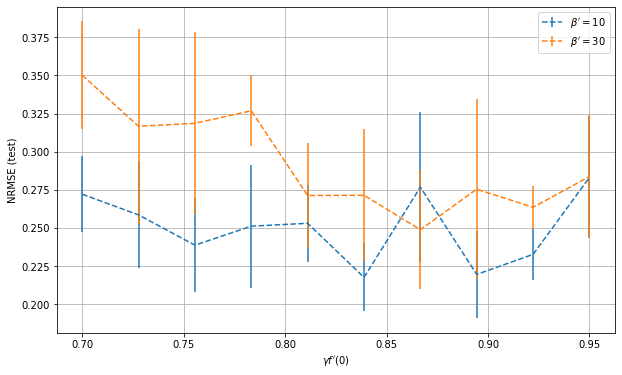

In [50]:
plt.figure(figsize=(10,6))
for i in range(len(bp_list)):
    bp = bp_list[i]
    plt.errorbar(gamma_fp0_list,NRMSE_test_mean_vs_bp[i],NRMSE_test_std_vs_bp[i],linestyle = '--',label=r'$\beta^\prime = $'+str(bp))
plt.grid(True)
plt.legend(loc="best")
plt.xlabel(r'$\gamma f^\prime(0)$')
plt.ylabel("NRMSE (test)")
#plt.xscale("log")
plt.show()

In [ ]:
NL_list = np.linspace()
Offset_list = np.linspace()

Ntrain = 1000
Nvalid = 1000
Ntest = 500

Nv = 400
T_theta = .3
gamma = _
beta_prime = 10

NRMSE_train_mean = np.zeros((len(Offset_list),len(NL_list)))
NRMSE_valid_mean = np.zeros((len(Offset_list),len(NL_list)))
NRMSE_test_mean = np.zeros((len(Offset_list),len(NL_list)))
    
#Constants
(u,y) = NARMA10(Ntrain)
spn = SPN.SP_Network(h,theta_H,k_s_0,phi,bp)
f_m = spn.get_f_m_eq()
dx = 5e-2
fp0 = (f_m(dx/2)-f_m(-dx/2))/(dx)
f_inf = f_m(1)
U = max(u)-min(u)

for i in range(len(Offset_list)):
    Offset = Offset_list[i]
    k_offset = Offset*f_inf/fp0
    
    for j in range(len(NL_list)):
        NL = NL_list[j]
        m0 = NL*f_inf/(U*fp0)

        NRMSE_train = []
        NRMSE_valid = []
        NRMSE_test = []

        N = 1

        for i in range(N):
            
            (u,y) = NARMA10(Ntrain)
            (u_valid,y_valid) = NARMA10(Nvalid)
            (u_test,y_test) = NARMA10(Ntest)
            
            net = Single_Node_Reservoir_NARMA10(Nv,T_theta,m0,gamma,beta_prime=bp,k_off=k_offset)

            S = net.gen_signal_fast_delayed_feedback(u,1)
            S_valid = net.gen_signal_fast_delayed_feedback(u_valid,1)
            S_test = net.gen_signal_fast_delayed_feedback(u_test,1)
            net.train(S,y,S_valid,y_valid)

            y_pred_train = net.predict(S)
            y_pred_valid = net.predict(S_valid)
            y_pred_test = net.predict(S_test)

            NRMSE_train.append(NRMSE_list(y,y_pred_train))
            NRMSE_valid.append(NRMSE_list(y_valid,y_pred_valid))
            NRMSE_test.append(NRMSE_list(y_test,y_pred_test))

        NRMSE_train_mean[i,j] = np.mean(NRMSE_train)
        NRMSE_valid_mean[i,j] = np.mean(NRMSE_valid)
        NRMSE_test_mean[i,j] = np.mean(NRMSE_test)

In [37]:
(u,y) = NARMA10(Ntrain)
spn = SPN.SP_Network(h,theta_H,k_s_0,phi,10)
f_m = spn.get_f_m_eq()
dx = 5e-2
fp0 = (f_m(dx/2)-f_m(-dx/2))/(dx)
f_inf = f_m(1)
U = max(u)-min(u)
print(7e-2*fp0*U/f_inf)
print(fp0*0.28)

0.13857610063928227
0.8916478887863281


In [26]:
Ntrain = 1000
Nvalid = 1000

(u,y) = NARMA10(Ntrain)
(u_valid,y_valid) = NARMA10(Nvalid)

net = Single_Node_Reservoir_NARMA10(1600,1e-1,7e-2,0.28)
S = net.gen_signal_fast_delayed_feedback(u, 3)
S_valid = net.gen_signal_fast_delayed_feedback(u_valid, 3)

net.train(S,y,S_valid,y_valid)

y_pred_train = net.predict(S)
y_pred_valid = net.predict(S_valid)

Ntest = 500
(u_test,y_test) = NARMA10(Ntest)
S_test = net.gen_signal_fast_delayed_feedback(u_test,3)
y_pred_test = net.predict(S_test)

Use bias
0
100
200
300
400
500
600
700
800
900
1000
Use bias
0
100
200
300
400
500
600
700
800
900
1000
alpha = 0.0 ; NRMSE (train) = 0.0 ; NRMSE (validation) = 0.216
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.0 ; NRMSE (validation) = 0.216
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.0 ; NRMSE (validation) = 0.216
alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.0 ; NRMSE (validation) = 0.216
alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.0 ; NRMSE (validation) = 0.216
alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.0 ; NRMSE (validation) = 0.216
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.038 ; NRMSE (validation) = 0.216
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.002 ; NRMSE (validation) = 0.216
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.0 ; NRMSE (validation) = 0.216
alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.0 ; NRMSE (validation) = 0.216
alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.0 ; NRMSE (validation) = 0.216
alpha = 4.832930

NRMSE (test) = 0.1755600064684327


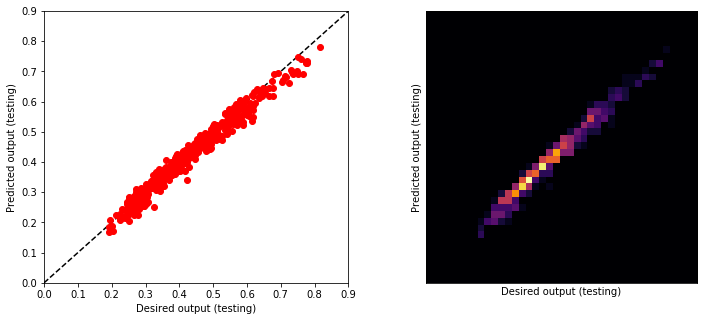

In [27]:
print("NRMSE (test) = "+str(NRMSE_list(y_test,y_pred_test)))
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(np.linspace(0,1.0),np.linspace(0,1.0), 'k--' )
plt.plot(y_test,y_pred_test,'ro')
plt.xlabel("Desired output (testing)")
plt.ylabel("Predicted output (testing)")
plt.xlim(0,0.9)
plt.ylim(0,0.9)
plt.subplot(122)
nbins = int(2*np.sqrt(Ntest))
H, xedges, yedges  = np.histogram2d(y_test,y_pred_test,bins = nbins,range=[[0, 1], [0, 1]])
H = H.T
plt.imshow(H,origin='low',cmap='inferno')
plt.xlabel("Desired output (testing)")
plt.ylabel("Predicted output (testing)")
plt.xticks([],[''])
plt.yticks([],[''])
plt.xlim(0,0.9*nbins)
plt.ylim(0,0.9*nbins)
plt.show()